In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# 1. Создание карты с кластерными метками:

*Кластерные метки* - это метки на карте, которые при отдалении схлопываются в объединенные кружочки (для экономии ресурса)

In [2]:
# создаем тестовый датафрейм:

import pandas as pd

data = {
    'latitude': [40.7128, 34.0522, 41.8781, 51.5074, 37.7749, 33.6844, 39.9042, 48.8566, 35.682839, 55.7558],
    'longitude': [-74.0060, -118.2437, -87.6298, -0.1278, -122.4194, -117.8265, 32.9297, 2.3522, 139.759455, 37.6176],
    'name': ['New York', 'Los Angeles', 'Chicago', 'London', 'San Francisco', 'San Diego', 'Beijing', 'Paris', 'Tokyo', 'Moscow']
}

df = pd.DataFrame(data)

df.head()

,latitude,longitude,name
0,40.7128,-74.0060,New York
1,34.0522,-118.2437,Los Angeles
2,41.8781,-87.6298,Chicago
3,51.5074,-0.1278,London
4,37.7749,-122.4194,San Francisco


# 2. Создание карты с обычными метками:

In [13]:
import folium

map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=row['name'],
        color='red',  
        fill=True,
        fill_color='red',
        fill_opacity=0.9
    ).add_to(map)

map

# 3. Как нарисовать polygon вручную:

Cайт: https://geojson.io

Это сайт где можно интерактивно нарисовать на карте произвольный полигон и получить его код в виде geojson.

Например, мы нарисовали полигон и скопировали справа его geojson:

In [14]:
from shapely.geometry import Polygon

In [15]:
# функция, конвертирующая geojson в Polygon:

def get_polygon_from_dict(geojson):
    coordinates_list = geojson['features'][0]['geometry']['coordinates'][0]
    return Polygon(coordinates_list)

In [16]:
# geojson МКАДа (нарисовали на https://geojson.io):

mkad_geojson = \
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              37.36773395055624,
              55.72929672787845
            ],
            [
              37.50678467194513,
              55.60452974307799
            ],
            [
              37.67742371234735,
              55.5795303356455
            ],
            [
              37.83547407889503,
              55.658050034561654
            ],
            [
              37.84493539573907,
              55.80751728021505
            ],
            [
              37.72167845864138,
              55.88734742173864
            ],
            [
              37.56682932930957,
              55.91037857344125
            ],
            [
              37.39618717366926,
              55.864282386046455
            ],
            [
              37.36773395055624,
              55.72929672787845
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [17]:
# получаем полигон:
mkad_polygon = get_polygon_from_dict(mkad_geojson)

In [18]:
type(mkad_polygon)

shapely.geometry.polygon.Polygon

# 4. Создание карты с полигонами:

In [19]:
import folium

In [20]:
# простая карта:

m = folium.Map(location=[55.7558, 37.6176], zoom_start=9)

folium.GeoJson(mkad_polygon).add_to(m)

m

In [21]:
# Добавляем цвет и аттрибуты полигону:

m = folium.Map(location=[55.7558, 37.6176], zoom_start=9)

folium.GeoJson(
    mkad_polygon,
    style_function=lambda feature: { # цвет полигона
        'color': 'red',
        'weight': 2,
        'fillOpacity': 0.5},
    
    tooltip=folium.Tooltip('мкад') # всплывающая надпись
    
).add_to(m)

# display the map:
m

# 5. Объединение полигонов:

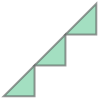

In [22]:
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

# примеры полигонов:
polygon1 = Polygon([(0, 0), (1, 0), (1, 1)])
polygon2 = Polygon([(1, 1), (2, 1), (2, 2)])
polygon3 = Polygon([(2, 2), (3, 2), (3, 3)])

# объединяем:
list_of_polygons = [polygon1, polygon2, polygon3]
united_polygon = cascaded_union(list_of_polygons)

united_polygon

# 6. Как записать полигон в виде строки и конвертировать обратно в shapely.geometry.polygon.Polygon:

In [23]:
from shapely.geometry import Polygon
from shapely import wkt

# пример полигона:
polygon1 = Polygon([(0, 0), (1, 0), (1, 1)])

# конвертируем в строку:
str_polygon = str(polygon1)

# конвертируем в полигон:
polygon2 = wkt.loads(str_polygon)
type(polygon2)

shapely.geometry.polygon.Polygon

# 7. Функция получения ссылки на Я.Карту из координат:

In [24]:
def get_yandex_map_url(latitude:float, longitude:float, zoom: int=18) -> str:

    """
    Метод для получения ссылки на Карту Яндекс с отмеченной коордиантой
    
    Parameters:
    latitude: float - широта
    longitude: float - долгота
    zoom: int - степень зумммирования
    
    Returns:
    str - URL карты
    """
    
    return f"https://yandex.ru/maps/?ll={longitude},{latitude}&mode=whatshere&whatshere[point]={longitude},{latitude}&whatshere&z={zoom}"

In [25]:
# центр Санкт-Петербурга:
get_yandex_map_url(59.9343, 30.3351)

'https://yandex.ru/maps/?ll=30.3351,59.9343&mode=whatshere&whatshere[point]=30.3351,59.9343&whatshere&z=18'

# 8. Как определить население в радиусе n метров вокруг точек (ПВЗ):

In [26]:
import pandas as pd
import numpy as np
import geopandas as gpd
from random import randint

In [27]:
# датафрейм с коордиантами домов и их населением (пример):

houses = pd.DataFrame({
    'latitude': np.random.uniform(55.5617, 55.9119, 10000),
    'longitude': np.random.uniform(37.3587, 37.9368, 10000),
    'people': np.random.randint(1, 1000, 10000)
})

out_gdf = gpd.GeoDataFrame(houses, geometry=gpd.points_from_xy(houses.longitude, houses.latitude))
out_gdf.head()

,latitude,longitude,people,geometry
0,55.875103,37.508765,101,POINT (37.50876 55.87510)
1,55.776994,37.652432,576,POINT (37.65243 55.77699)
2,55.679255,37.678029,24,POINT (37.67803 55.67925)
3,55.583259,37.596031,885,POINT (37.59603 55.58326)
4,55.761906,37.811771,831,POINT (37.81177 55.76191)


In [28]:
# датафрейм с коордианатами пунктов выдачи (пример):

pvz = pd.DataFrame({
    'pvz_id':[f'000000{randint(100000,200000)}' for i in range(100)],
    'latitude': np.random.uniform(55.5617, 55.9119, 100),
    'longitude': np.random.uniform(37.3587, 37.9368, 100)
})

pvz.head()

,pvz_id,latitude,longitude
0,000000197461,55.571576,37.785091
1,000000148658,55.712783,37.619444
2,000000112160,55.585382,37.386151
3,000000197801,55.873644,37.742097
4,000000167865,55.837506,37.571826


In [29]:
# функция рисования кругов вокруг ПВЗ:

import geopandas as gpd
import json
from functools import partial
import pyproj
from shapely import geometry
from shapely.geometry import Point
from shapely.ops import transform
import warnings
warnings.filterwarnings('ignore')


def create_circle(lat, lon, radius=1000):

    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(lat, lon)
    
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )

    center = Point(float(lon), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    buffer = point_transformed.buffer(radius)
    circle_poly = transform(aeqd_to_wgs84, buffer)
    
    return circle_poly

In [30]:
# рисуем круги вокруг ПВЗ:
pvz['geometry'] = pvz.apply(lambda row: create_circle(lat=row['latitude'], lon=row['longitude'], radius=500), axis=1)

In [32]:
# узнаем сколько людей живет в кругах:
pvz = gpd.GeoDataFrame(pvz, geometry='geometry', crs='EPSG:4326')
data_house_pvz = pvz.sjoin(out_gdf, how='left')

people_in_500m = data_house_pvz.groupby(['pvz_id'], as_index=False)\
                               .agg({'people':'sum'})\
                               .rename(columns={'people':'people_in_500m'})

people_in_500m

,pvz_id,people_in_500m
0,000000100423,3095
1,000000100491,3272
2,000000100638,2598
3,000000103369,3807
4,000000103391,4232
...,...,...
95,000000198075,2942
96,000000198148,2331
97,000000198420,1854
98,000000198762,2821


# 9. Функция, к-рая возвращает дистанцию между двумя коордианатами в километрах:

In [139]:
from geopy.distance import geodesic 

# функция, к-рая возвращает дистанцию между двумя коордианатами в километрах:
def get_dist(lat1, lon1, lat2, lon2):
    
    coords1 = (lat1, lon1)
    coords2 = (lat2, lon2)
    
    try: 
        return geodesic(coords1, coords2).kilometers
    except:
        return None 

In [140]:
# Пример:
moscow_coords = (55.7558, 37.6176) # Москва
spb_coords = (59.9343, 30.3351) # Санкт-Петербург

# Вычисляем расстояние
get_dist(moscow_coords[0], moscow_coords[1], spb_coords[0], spb_coords[1])

634.6140179781821

# 10. Функции из сервиса  OpenRouteService:

In [59]:
# pip install openrouteservice

Чтобы получить токен, надо зайти на https://openrouteservice.org, нажать **Log In**, зарегистрироваться и потом нажать **Tokens**

In [89]:
token = '5b3ce3597851110001cf6248b44b7786dae045c4a797166b65840f9c'

## Функция получения полигона n-минутной пешей доступности:

In [132]:
import requests
from shapely.geometry import shape, Polygon

def get_feet_isochrone_polygon(latitude:float, longitude:float, token:str, minutes=7):
    """
    Функция для получения зоны пешей n-минутной доступности с OpenRouteService
    
    Parameters:
    latitude: float - широта исходной точки
    longitude: float - долгота исходной точки
    minutes: int - количество минут для зоны доступности (по умолчанию 7 минут)
    token: str - API ключ для доступа к OpenRouteService
    
    Returns: shapely.geometry.polygon.Polygon
    """
    
    try:
        iso_params = {
            'locations': [[longitude, latitude]],
            'profile': 'foot-walking',
            'range': [minutes * 60], 
            'attributes': ['total_pop', 'area'] # получаем в ответе запросы населени и площадь полигона
        }
        
        headers = {
            'Authorization': token,
            'Content-Type': 'application/json'
        }
        
        url = 'https://api.openrouteservice.org/v2/isochrones/foot-walking'
        response = requests.post(url, headers=headers, json=iso_params)
        response.raise_for_status()  # Проверка на ошибки
        
        response_data = response.json()
        polygon = shape(response_data['features'][0]['geometry'])
        return polygon
    
    except Exception as err:
        print(f"Error occurred: {err}")
        return None

In [133]:
# Пример:

latitude = 55.7558
longitude = 37.6176
minutes = 60
token = '5b3ce3597851110001cf6248b44b7786dae045c4a797166b65840f9c'  

polygon = get_isochrone_polygon(latitude, longitude, token, minutes)

type(polygon)

shapely.geometry.polygon.Polygon

In [134]:
# визуализируем результат (60-минутная пешая доступность от центра Москвы):
import folium
m = folium.Map(location=[55.7558, 37.6176], zoom_start=12)
folium.GeoJson(polygon).add_to(m)
folium.CircleMarker(location=[55.7558, 37.6176], color='red', fill=True, fill_color='red', fill_opacity=0.9).add_to(m)
m

## Функция построения маршрута между двумя точками:

In [135]:
from openrouteservice import client
from shapely.geometry import LineString

# инициализируем клиента OpenRouteService:
token = '5b3ce3597851110001cf6248b44b7786dae045c4a797166b65840f9c'  
ors = client.Client(key=token)

# функция:
def create_route(latitude1: float, longitude1: float, latitude2: float, longitude2: float):
    """
    Функция для построения маршрута между двумя точками (точки должны быть достижимы по дороге)
    
    Parameters:
    latitude1: float - широта начальной точки
    longitude1: float - долгота начальной точки
    latitude2: float - широта конечной точки
    longitude2: float - долгота конечной точки
    
    Returns: shapely.geometry.LineString - линия маршрута
    """
    try:
        coordinates = [[longitude1, latitude1], [longitude2, latitude2]]
        route_request = {
            'coordinates': coordinates,
            'format_out': 'geojson',
            'profile': 'driving-car',
            'preference': 'shortest',
            'instructions': False
        }
        
        route_directions = ors.directions(**route_request)
        route = LineString(route_directions['features'][0]['geometry']['coordinates'])
        return route
    
    except Exception as err:
        print(f"Error occurred: {err}")
        return None

In [136]:
# Пример:

latitude1 = 55.7558  # Москва
longitude1 = 37.6176
latitude2 = 59.9343  # Санкт-Петербург
longitude2 = 30.3351

route = create_route(
    latitude1=latitude1,
    longitude1=longitude1,
    latitude2=latitude2,
    longitude2=longitude2,
)

type(route)

shapely.geometry.linestring.LineString

In [137]:
# визуализируем результат (маршрут Москва - Санкт-Петербург):
import folium
m = folium.Map(location=[55.7558, 37.6176], zoom_start=5)
folium.GeoJson(route, name="Маршрут").add_to(m)
folium.Marker([latitude1, longitude1], popup="Начальная точка", icon=folium.Icon(color='green')).add_to(m)
folium.Marker([latitude2, longitude2], popup="Конечная точка", icon=folium.Icon(color='red')).add_to(m)
m